# Convolutional Autoencoder

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

### Description

Convolutional autoencoder for a compressed representation of the MNIST dataset.

### GPU

Training a convolutional neural network (CNN) can quickly become computationally expensive, especially for large images and a large number of convolutional filters. For this reason we should offload the forward pass and backpropagation to a graphic processing unit (GPU), if it is available. We can write general code that works both on a CPU and a GPU buy defining a `device`:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Set

### Data Transformation

In [ ]:
transform = transforms.ToTensor()

In [ ]:
trainset = datasets.MNIST(root="", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="", train=False, download=True, transform=transform)


In [ ]:
print(f"Number of training examples: {len(trainset)}")
print(f"Number of testing examples: {len(testset)}")

Number of training examples: 60000
Number of testing examples: 10000


### Data Loaders

We can now define a `torch.utils.data.DataLoader` which loads the datasets in randomly shuffled batches:

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Finally, we can define iterators to iterate over `tranloader`, and `testloader` batches:

In [ ]:
trainiter = iter(trainloader)
testiter = iter(testloader)

#### Visualizing Images and Labels

 W` convention (where C is number of channels, H the image height and W the image width) while `matplotlib` uses the `H x W x C` convention. This means that we have to transpose our tensor from `C x H x W` to  `H x W x C`.

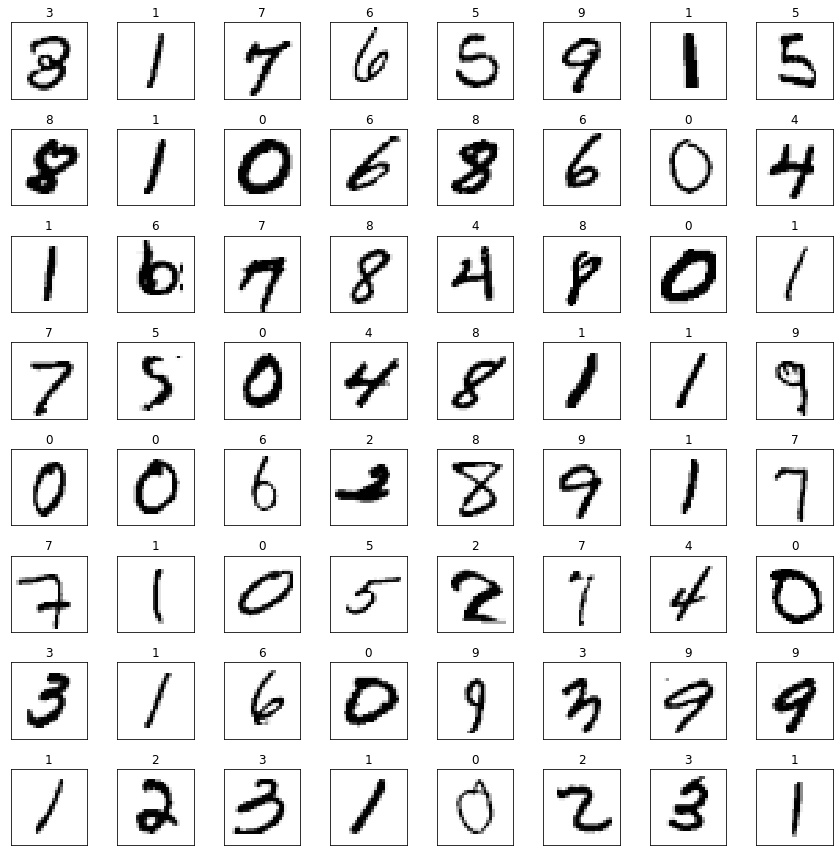

In [ ]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze()

    # Transpose image from C x H x W to H x W x C
    plt.imshow(img, cmap='Greys')
    
    # Get name
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Convolutional Autoencoder

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))

        return x

### Autoencoder

In [ ]:
from collections import OrderedDict

In [ ]:
autoencoder = nn.Sequential(OrderedDict([("encoder", Encoder()), ("decoder", Decoder())]))
autoencoder.to(device)

Sequential(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

### Training

In [ ]:
# Extract first batch of images
images, labels = next(trainiter)

# Move images and labels to the GPu
images, labels = images.to(device), labels.to(device)

# Forward pass
out = autoencoder(images)

# Check output shape
assert out.shape == images.shape

In order to train the model we have to define a loss function. Since our model output comes from a linear layer, we need to use the cross entropy loss:

In [ ]:
mse_loss = nn.MSELoss()

Then we need to define an optimizer and link it to the model parameters. Here we use the [Adam optimizer](https://arxiv.org/abs/1412.6980).

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.003)

Finally we can train our network. In order to speedup the training loop we can use the `torch.no_grad()` context manager so that expensive gradient computations are avoided during the validation phase.

In [ ]:
from tqdm import tqdm

def train(model, optimizer, loss_function, epochs=15, device=device):
    """
    Train a model by ooptimizing a loss_function using the given optimizer.
    Model and data are moved to the set device.
    """

    import time

    # Move model to device
    model.to(device)

    train_losses = []

    # Loop over epochs
    for epoch in range(epochs):

        # Start epoch timer
        time_init = time.time()
        
        # Initialize total epoch loss
        epoch_loss = 0
        
        # Training
        for images, _ in tqdm(trainloader):

            # Move data to GPU
            images = images.to(device)
        
            # Initialize the gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            output = model(images)
            
            # Compute the loss
            loss = loss_function(output, images)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Accumulate total epoch loss
            epoch_loss += loss.item()
                    
        # Store losses
        train_losses.append(epoch_loss/len(trainloader))

        # Stop epoch timer
        time_end = time.time()
                
        print(f"\n--- Epoch {epoch+1:2} ---")
        print(f"Train Loss: {train_losses[-1]:.5f}")
        print(f"Time: {time_end - time_init:.3f} s")
    
    return train_losses

In [ ]:
# Define the number of training epochs
epochs = 30

train_losses = train(autoencoder, optimizer, mse_loss, epochs, device)

  0%|          | 4/938 [00:00<00:24, 38.37it/s]
--- Epoch  1 ---
Train Loss: 0.01103
Time: 22.170 s
  1%|          | 5/938 [00:00<00:22, 40.78it/s]
--- Epoch  2 ---
Train Loss: 0.01101
Time: 22.012 s
  1%|          | 5/938 [00:00<00:22, 41.50it/s]
--- Epoch  3 ---
Train Loss: 0.01099
Time: 21.869 s
  0%|          | 4/938 [00:00<00:24, 37.96it/s]
--- Epoch  4 ---
Train Loss: 0.01098
Time: 21.242 s
  0%|          | 4/938 [00:00<00:25, 36.10it/s]
--- Epoch  5 ---
Train Loss: 0.01097
Time: 22.171 s
  1%|          | 5/938 [00:00<00:22, 42.22it/s]
--- Epoch  6 ---
Train Loss: 0.01095
Time: 21.698 s
  0%|          | 4/938 [00:00<00:23, 39.62it/s]
--- Epoch  7 ---
Train Loss: 0.01094
Time: 22.256 s
  1%|          | 8/938 [00:00<00:23, 39.90it/s]
--- Epoch  8 ---
Train Loss: 0.01093
Time: 22.122 s
  0%|          | 4/938 [00:00<00:24, 37.42it/s]
--- Epoch  9 ---
Train Loss: 0.01092
Time: 22.148 s
  1%|          | 5/938 [00:00<00:22, 42.31it/s]
--- Epoch 10 ---
Train Loss: 0.01091
Time: 22.271 s


## Testing the  Model

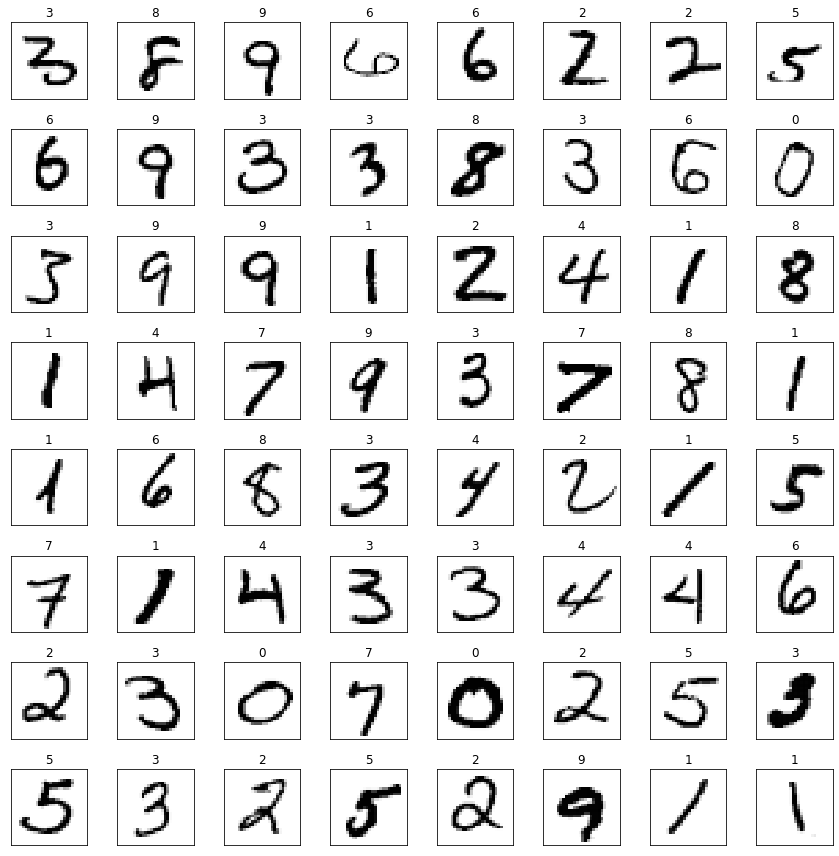

In [ ]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze()

    # Transpose image from C x H x W to H x W x C
    plt.imshow(img, cmap='Greys')
    
    # Get name
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

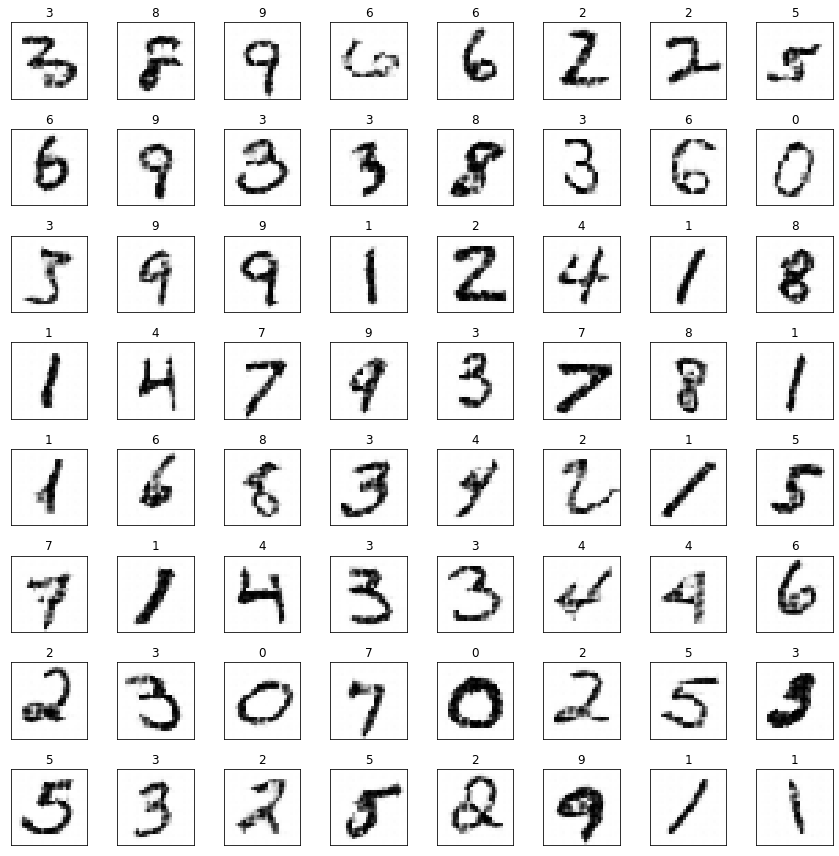

In [ ]:
decoded = autoencoder(images)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = decoded[idx].detach().numpy().squeeze()

    # Transpose image from C x H x W to H x W x C
    plt.imshow(img, cmap='Greys')
    
    # Get name
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()